In [1]:
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
df2 = pd.read_excel('Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')
df = df2.copy()
df['Si_mM'] = df['Si_ppm'] / 28.0855
df['Si_mol_m3'] = df['Si_mM'] * 1e-3
variable = 'Si_mol_m3'
min_variable = df[variable].min()
max_variable = df[variable].max()
df["z'"] = (df[variable] - min_variable) / (max_variable - min_variable)


In [3]:
# Function to calculate N_D
def calculate_ND(phi, t, C0, k, A_s):
    return t * k * A_s / (phi * C0)

# Function to calculate EE
def EE(z, N_D, f, C0):
    dz = z[1] - z[0]  # Step size
    C = np.zeros_like(z)
    C[0] = C0
    for i in range(1, len(z)):
        C[i] = C[i-1] + dz * N_D * (1 - f)
    return C

In [4]:
# Reaction rate and surface area
log_k = -11.2
k = np.exp(log_k)
A_s = 1  # Example

# Observed data
z_observed = df["z'"].values
C_observed = df[variable].values

# Grid for model evaluation
z_grid = np.linspace(0, 1, 100)

In [13]:
# Define the log likelihood
def log_likelihood(params, z_observed, C_observed, C0, k, A_s):
    phi, t, f = params
    if phi <= 0 or phi > 0.1 or t <= 86400 or t > 3153600000 or f < 0 or f > 1:
        return -np.inf  # Reject out-of-bounds samples
    N_D = calculate_ND(phi, t, C0, k, A_s)
    C_model = EE(z_grid, N_D, f, C0)
    C_model_interp = np.interp(z_observed, z_grid, C_model)
    sigma = 0.1  # Measurement error
    return -0.5 * np.sum(((C_observed - C_model_interp) / sigma) ** 2)

# Define the log prior
def log_prior(params):
    phi, t, f = params
    if 0.01 <= phi <= 0.1 and 86400 <= t <= 3153600000 and 0 <= f <= 1:
        return 0.0  # Uniform prior
    return -np.inf

# Define the log posterior
def log_posterior(params, z_observed, C_observed, C0, k, A_s):
    phi, t, f = params
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf  # Reject invalid prior values
    ll = log_likelihood(params, z_observed, C_observed, C0, k, A_s)
    if not np.isfinite(ll):
        return -np.inf  # Reject invalid likelihood values
    return lp + ll

# Set up MCMC sampler
ndim = 3  # Number of parameters (phi, t, f)
nwalkers = 50  # Number of walkers
nsteps = 5000  # Number of steps per walker
initial_guess = [0.05, 1e7, 0.5]
initial_pos = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run MCMC sampling
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(z_observed, C_observed, min_variable, k, A_s)
)
sampler.run_mcmc(initial_pos, nsteps, progress=True)


You must install the tqdm library to use progress indicators with emcee


State([[5.00583825e-02 1.00000000e+07 5.00094949e-01]
 [5.02232846e-02 1.00000000e+07 4.99915333e-01]
 [5.00673500e-02 1.00000000e+07 5.00077662e-01]
 [4.99994590e-02 1.00000000e+07 4.99836106e-01]
 [5.00239359e-02 1.00000000e+07 4.99888643e-01]
 [5.01384608e-02 1.00000000e+07 5.00037713e-01]
 [4.99670832e-02 1.00000000e+07 4.99949757e-01]
 [4.99092514e-02 1.00000000e+07 4.99975794e-01]
 [5.00801925e-02 1.00000000e+07 5.00095001e-01]
 [5.01296946e-02 1.00000000e+07 4.99848927e-01]
 [4.97894518e-02 1.00000000e+07 5.00071630e-01]
 [5.00218373e-02 1.00000000e+07 4.99688458e-01]
 [4.98949161e-02 1.00000000e+07 5.00038340e-01]
 [5.00334002e-02 1.00000000e+07 4.99985329e-01]
 [5.01625992e-02 1.00000000e+07 5.00050507e-01]
 [5.02084582e-02 1.00000000e+07 5.00017556e-01]
 [4.99899486e-02 1.00000000e+07 4.99946252e-01]
 [4.99772080e-02 1.00000000e+07 4.99990492e-01]
 [4.99389823e-02 1.00000000e+07 4.99959266e-01]
 [4.98809643e-02 1.00000000e+07 5.00036756e-01]
 [4.99672339e-02 1.00000000e+07 5.

In [ ]:
# Analyze results
samples = sampler.get_chain(flat=True)
phi_post, t_post, f_post = np.mean(samples, axis=0)
print(f"Posterior mean of porosity (phi): {phi_post}")
print(f"Posterior mean of time (t in years): {t_post / (365 * 24 * 3600)}")
print(f"Posterior mean of fraction of reaction (f): {f_post}")

# Plot observed vs modeled
posterior_N_D = calculate_ND(phi_post, t_post, min_variable, k, A_s)
posterior_C_model = EE(z_grid, posterior_N_D, f_post, min_variable)


posterior_C_model_interp = np.interp(z_observed, z_grid, posterior_C_model)


Posterior mean of porosity (phi): 0.05000312413096006
Posterior mean of time (t in years): 0.31709791983785524
Posterior mean of fraction of reaction (f): 0.4999834334707651


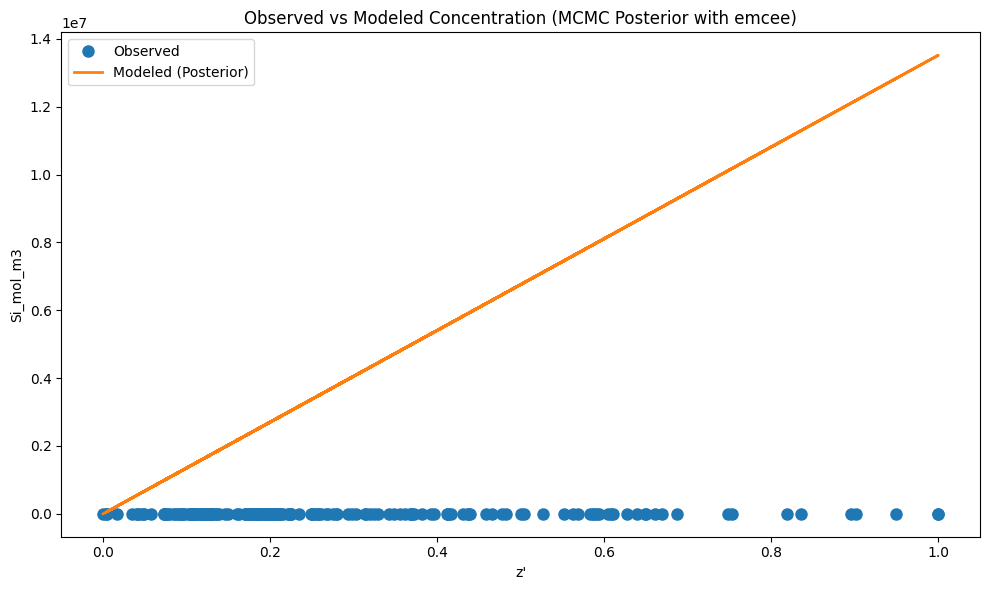

In [27]:

plt.figure(figsize=(10, 6))
plt.plot(z_observed, C_observed, 'o', label='Observed', markersize=8)
plt.plot(z_observed, posterior_C_model_interp, '-', label='Modeled (Posterior)', linewidth=2)
plt.xlabel("z'")
plt.ylabel(variable)
plt.title("Observed vs Modeled Concentration (MCMC Posterior with emcee)")
plt.legend()
plt.tight_layout()
plt.show()